In [14]:
%run qae_utils.py
from qae_utils import *
from typing import Iterable, Optional, Union

In [2]:
from scipy.optimize import minimize

In [3]:
## define the grover operator ~
p = 0.2
initial_state_prep = s_psi0(p)
grv_op = Q(p, 1)

In [4]:
from qiskit import *

##### #Phase0: 

In [5]:
def qpe(p: float, trainable:bool= False, p_param:Union[float, None]= None , precision:int= 4, no_estimates:int= 5 ):
    
    ## define the grover operator ~
    p = 0.25

    # precision= 4
    ## generate the Quantum Circuit ~
    preg = QuantumRegister(precision, name= 'precision_q')
    qreg = QuantumRegister(1, name='qreg')
    creg = ClassicalRegister(precision, name='precision_c')
    qc = QuantumCircuit(preg,qreg, creg)

    qc.h(preg)
    qc.append(s_psi0(p), [precision] )
    qc.barrier()

    if trainable== True:
        for q in range(precision):
            qc.append(Q( p_param  , 2**q).to_gate().control(1), [q]+list(range(precision,precision+1)) )
    
    else:
        for q in range(precision):
            qc.append(Q(p,2**q).to_gate().control(1), [q]+list(range(precision,precision+1)) )

    qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
    qc.barrier()
    qc.append(qftgate_inv, list(range(precision)))

    qc.measure(preg, creg)
    shots = 2000
    job = execute(qc, backend= aer, shots= shots)
    counts = job.result().get_counts()

    # no_estimates= 5
    estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
    p_est = 0
    for p in range(no_estimates): 
        p_est += np.sin(int(estimate[p][1], 2)*pi/(2**precision))**2 * (estimate[p][0]/ shots)

    return p_est


def to_minimize(p_params, p , precision:int= 4, no_estimates:int= 5 ):
    p_est = qpe(p, trainable= True, p_param= p_params)
    cost = (p_params - p_est)**2

    return cost


In [6]:
qpe(0.25), qpe(0.25, trainable= True, p_param= 0.20)

(0.247887786810103, 0.16135307073253757)

In [40]:
p_guess = np.random.random()
p= 0.25

minimize(to_minimize, p_guess, (p), method= 'Nelder-Mead')

CircuitError: "Invalid param type <class 'numpy.ndarray'> for gate ry."

In [24]:
estimate

[(720, '0011'),
 (653, '1101'),
 (182, '0010'),
 (173, '1110'),
 (53, '0100'),
 (46, '1100'),
 (40, '0001'),
 (31, '1111'),
 (29, '0000'),
 (20, '0101'),
 (15, '1011'),
 (13, '1010'),
 (9, '0110'),
 (6, '1001'),
 (6, '1000'),
 (4, '0111')]

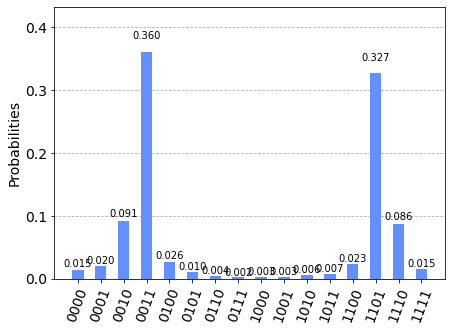

In [25]:
plot_histogram(counts)

In [26]:
p_est

0.2511381850103768

##### #Phase1
Prepare PQC to assist the state perparation circuit to be used inside the Grover Operator, $ \mathcal{\hat{Q}_{\beta}} $, where $\beta$ in the set of trainable paramters. (** For single qubit states only; oracle $\mathcal{\hat{O}_{\ket{1}}} = \hat{Z}$ and $\mathcal{\hat{O}_{\ket{0}}} = -\hat{Z}$ ).

$$ \mathcal{\hat{Q}_{\beta}} =  (\mathbb{\hat{I}} - 2 \ket{\tilde{\psi_0}(\beta)} \bra{\tilde{\psi_0}(\beta)} ) \: \mathcal{\hat{O}}
$$

Here the $\ket{\tilde{\psi_0}(\beta)}$ is approximated initial state and is prepard using the PQC as 
$$      \ket{\tilde{\psi_0}(\beta)}\ket{\Gamma_{\beta}} = \mathcal{\hat{P}_{\beta}} ( \ket{0} \ket{\Gamma} )
$$
where $\Gamma$ denotes the ancilla qubits, and $\mathcal{\hat{P}_{\beta}}$ denotes the paramterised quantum circuit.

In [7]:
num_ancillas = 5

params_state = np.random.uniform(low=0, high= 2*pi, size= 2)
params_ancilla= np.random.uniform(low=0, high= 2*pi, size= 2*num_ancillas )

qreg = QuantumRegister(1, name= 'q')
ancillas = AncillaRegister(num_ancillas, name= 'ancilla')
qc = QuantumCircuit(qreg, ancillas)

## set_ansatz ~
qc.ry(params_state[0], qreg)
qc.cx(qreg, ancillas[0])

for index, ancilla in list(enumerate(ancillas))  :
    qc.ry(params_ancilla[index], ancilla)
    qc.cx(ancillas[index], ancillas[(index+1)%(num_ancillas)])
qc.barrier()
for index, ancilla in list(reversed(list(enumerate(ancillas))))  :
    qc.ry(params_ancilla[index], ancilla)
    qc.cx(ancillas[index], ancillas[(index-1)%(num_ancillas)])

qc.cx( ancillas[0], qreg)
qc.ry(params_state[1], qreg)


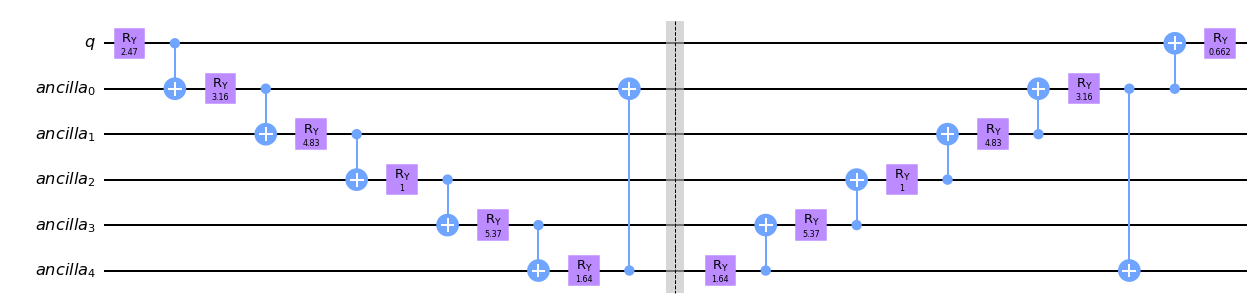

In [8]:
qc.draw(output= 'mpl')

In [106]:
class state_preparation_ansatz(QuantumCircuit):
    
    def __init__(self,
        num_ancillas: int,
        name: str= "Q",
        params: Optional[Union[Iterable, str, None]]= "random",
        insert_barrier:bool= False)-> None:

        super().__init__(name= name)

        ## set inputs ~
        self._num_ancillas= num_ancillas
        self._name= name
        self._insert_barrier= insert_barrier
        self._params= params
        self._num_params = self._num_ancillas * 3 + 2
        
        self._build(self._params)
        
        ## load custom params ~
        # self.load_params(params)
        # self._build()
        

    @property
    def num_ancillas(self):
        """ No, of ancillas used in the ansatz """
        return self._num_ancillas
    
    @property
    def num_params(self):
        """ No. of parmaters passed into the ansatz """
        return self._num_params

    def load_params(self, params: Iterable):

        # self.show_params()
        self._build(params)
        
    
    def show_params(self):
        print("\n params_state: ", self._params_state)
        print("\n params_ancillas_init: ", self._params_ancilla_init)
        print("\n params_ancillas: ", self._params_ancilla)
        print("\n params_ancillas_end: ", self._params_ancilla_end)

    def _build(self, params):

        if params== "random":

            self._params_state = np.random.uniform(low=0, high= 2*pi, size= 2)
            self._params_ancilla= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )
            self._params_ancilla_init= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )
            self._params_ancilla_end= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )

       
        elif isinstance(params, Iterable):

            if len(params) != self._num_params: raise ValueError(" no. of elements in 'params' must be ", self._num_params )
            self._params_state= params[:2]
            self._params_ancilla_init= params[2: 2 + self._num_ancillas]
            self._params_ancilla= params[2 + self._num_ancillas: 2 + 2 * self._num_ancillas]
            self._params_ancilla_end= params[2+ 2 * self._num_ancillas: 2 + 3 * self._num_ancillas]

        params_state = self._params_state
        params_ancilla= self._params_ancilla
        params_ancilla_init= self._params_ancilla_init
        params_ancilla_end= self._params_ancilla_end

        qreg = QuantumRegister(1)
        ancillas = AncillaRegister(self._num_ancillas)
        qc = QuantumCircuit(qreg, ancillas)

        ## set_ansatz ~
        qc.h(ancillas)
        qc.ry(params_state[0], qreg)
        for index, ancilla in list(enumerate(ancillas))  : qc.ry(params_ancilla_init[index], ancilla)
        if self._insert_barrier == True: qc.barrier()

        qc.cx(qreg, ancillas[0])

        for index, ancilla in list(enumerate(ancillas))  :
            qc.ry(params_ancilla[index], ancilla)
            qc.cx(ancillas[index], ancillas[(index+1)%(self._num_ancillas)])
        
        if self._insert_barrier == True: qc.barrier()
        
        for index, ancilla in list(reversed(list(enumerate(ancillas))))  :
            qc.ry(params_ancilla[index], ancilla)
            qc.cx(ancillas[index], ancillas[(index-1)%(self._num_ancillas)])

        qc.cx( ancillas[0], qreg)
        
        if self._insert_barrier == True: qc.barrier()     
        for index, ancilla in list(enumerate(ancillas))  : qc.ry(params_ancilla_end[index], ancilla)   
        qc.ry(params_state[1], qreg)
        qc.h(ancillas)

        self.add_register(*qc.qregs)
        self.compose(qc, qubits= self.qubits, inplace= True)

           

In [107]:
x = state_preparation_ansatz(3, params= 'random', name= 'a', insert_barrier= True)

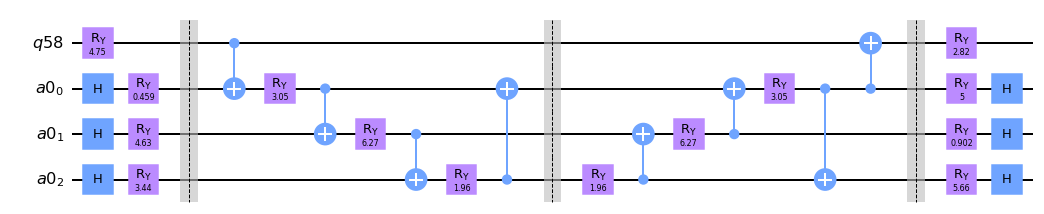

In [108]:
x.draw(output= 'mpl')

In [109]:
x.load_params( np.random.uniform(low=0, high= 2*pi, size= x.num_params )) 
x.draw(output= 'mpl')

/tmp/ipykernel_42229/414038598.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if params== "random":


CircuitError: 'Number of items in qubits parameter (8) does not match number of qubits in the circuit (4).'

In [42]:
def state_preparation_ansatz_fun(num_ancillas:int= 5, insert_barrier:bool= False)-> QuantumCircuit:
    r""" Circuit to prepare the paraterised 'QuantumCicruit' for preparing the initial state

        ARGS:
            

    """
    params_state = np.random.uniform(low=0, high= 2*pi, size= 2)
    params_ancilla= np.random.uniform(low=0, high= 2*pi, size= 2*num_ancillas )

    qreg = QuantumRegister(1, name= 'q')
    ancillas = AncillaRegister(num_ancillas, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancillas)

    ## set_ansatz ~
    qc.ry(params_state[0], qreg)
    qc.cx(qreg, ancillas[0])

    for index, ancilla in list(enumerate(ancillas))  :
        qc.ry(params_ancilla[index], ancilla)
        qc.cx(ancillas[index], ancillas[(index+1)%(num_ancillas)])
    
    if insert_barrier== True: qc.barrier()
    
    for index, ancilla in list(reversed(list(enumerate(ancillas))))  :
        qc.ry(params_ancilla[index], ancilla)
        qc.cx(ancillas[index], ancillas[(index-1)%(num_ancillas)])

    qc.cx( ancillas[0], qreg)
    qc.ry(params_state[1], qreg)

    return qc

def load_state_preparation_ansatz(params:Iterable ):
    qc = state_preparation_ansatz()



In [44]:
oracle = QuantumCircuit(1, name='oracle')
oracle.z(0)

state_preparation_circuit= state_preparation_ansatz_fun(insert_barrier= True)

In [45]:
gr_op = GroverOperator(oracle, state_preparation= state_preparation_circuit, insert_barriers= True)

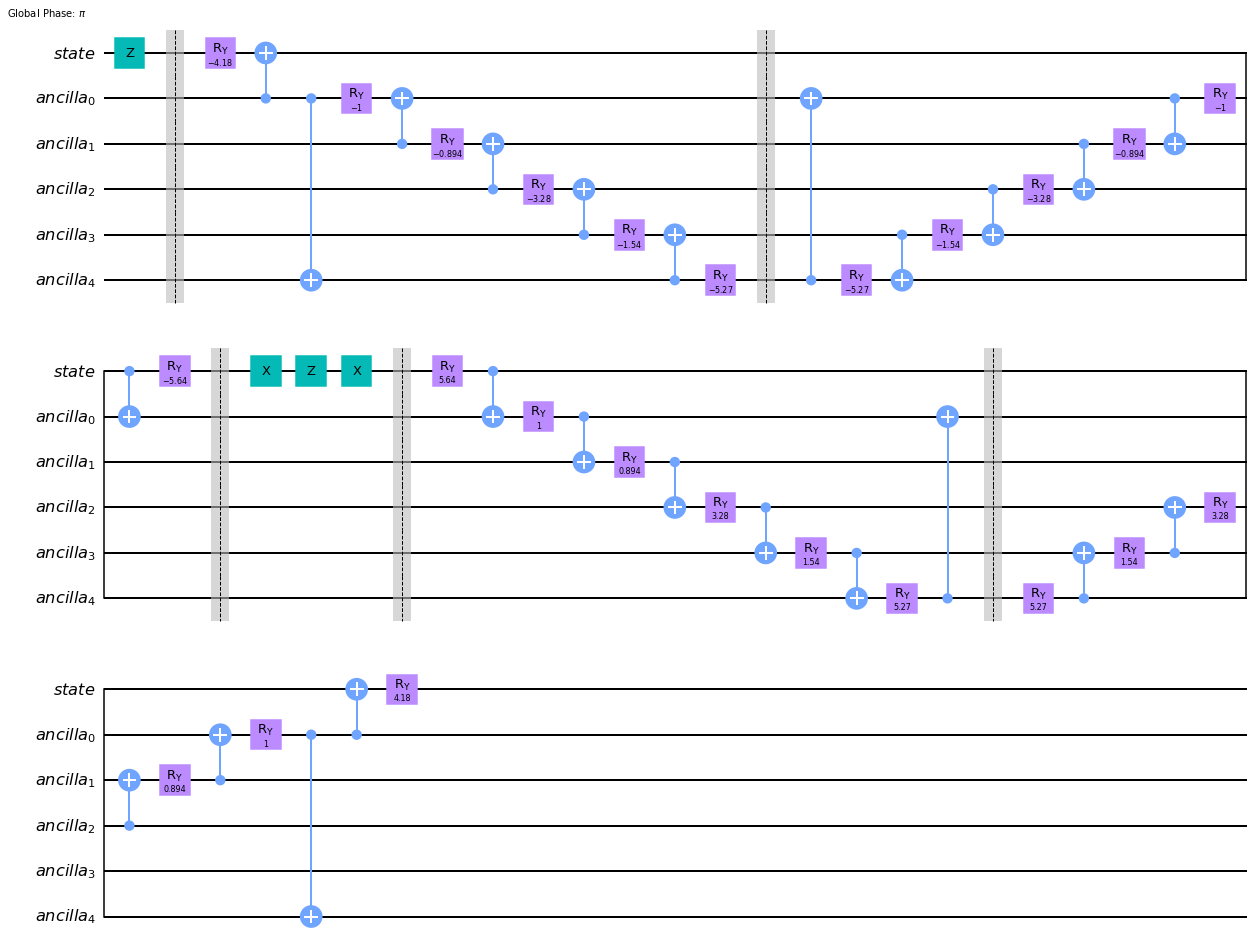

In [46]:
gr_op.decompose().draw(output= 'mpl')

[AncillaQubit(AncillaRegister(5, 'ancilla'), 0),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 1),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 2),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 3),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 4)]